In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

In [17]:
!pip install medmnist
from medmnist.dataset import PathMNIST

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

traindataset = PathMNIST(split='train', transform=data_transforms, download=True)
testdataset = PathMNIST(split='test', transform=data_transforms, download=True)

100%|████████████████████████████████████████████████████████████████████████████████| 206M/206M [08:14<00:00, 416kB/s]


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random


In [27]:
!pip install comet_ml 
import comet_ml
COMET_API_KEY = "FFQ44WfDfuhoH81iAcSQyFKC4"

assert torch.cuda.is_available()
assert COMET_API_KEY != ""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ---------------------------------------- 0.0/764.6 kB ? eta -:--:--
   ------------- -------------------------- 262.1/764.6 kB ? eta -:--:--
   ---------------------------------------- 764.6/764.6 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/833.9 kB ? eta -:--:--
   ------------------------- -------------- 524.3/833.9 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 833.9/833.9 kB 2.8 MB/s eta 0:00:00


In [29]:
comet_ml.login(project_name="MedMNIST_Experiment_CNN")
comet_model = comet_ml.Experiment()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ········


COMET INFO: Valid Comet API Key saved in C:\Users\jackh\.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jackh-99/medmnist-experiment-cnn/dfc779efedfd4c978b379f5c79445dc8



In [47]:
image, label = traindataset[0]
print(image.size())
print(label[0].item())


torch.Size([3, 28, 28])
0
torch.Size([3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823529..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5529412..0.77254903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69411767..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5058824..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26274508..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

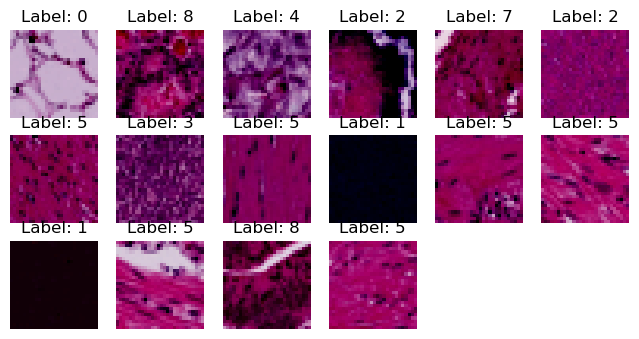

In [53]:
plt.figure(figsize=(8,8))
random_inds = np.random.choice(60000,36)
for i in range(16):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = traindataset[image_ind]
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.title(f"Label: {label[0].item()}")
comet_model.log_figure(figure=plt)
plt.show()

In [71]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,1)

        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32,40,3)

        self.pool2 = nn.MaxPool2d(2,2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(40 * 5 * 5, 128)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(128,9)

    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

model = CNN().to(device)
image, label = traindataset[0]
image = image.to(device).unsqueeze(0)
output = model(image)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1000, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


In [95]:
model = CNN().to(device)

batch_size = 128
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=2e-2)

loss_function = nn.CrossEntropyLoss()

trainset_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader(testdataset, batch_size=batch_size, shuffle=False)



In [77]:
from tqdm import tqdm

100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.73it/s]


Epoch 1, Loss: 0.013169931673443028, Accuracy: 0.3692


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 61.94it/s]


Epoch 2, Loss: 0.00933046507233487, Accuracy: 0.5462


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 60.77it/s]


Epoch 3, Loss: 0.007724396021129068, Accuracy: 0.6360


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 61.39it/s]


Epoch 4, Loss: 0.007056664670672468, Accuracy: 0.6694


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 63.27it/s]


Epoch 5, Loss: 0.006510472557556259, Accuracy: 0.6962


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:10<00:00, 67.09it/s]


Epoch 6, Loss: 0.006081447131109532, Accuracy: 0.7154


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 60.28it/s]


Epoch 7, Loss: 0.00575170291016391, Accuracy: 0.7325


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 60.40it/s]


Epoch 8, Loss: 0.00539313743930853, Accuracy: 0.7524


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 60.56it/s]


Epoch 9, Loss: 0.005149760189027361, Accuracy: 0.7634


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:10<00:00, 64.10it/s]


Epoch 10, Loss: 0.0049440336290203345, Accuracy: 0.7739


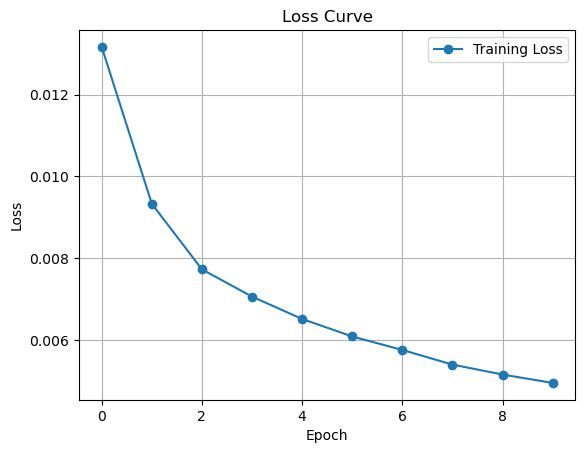

In [97]:
if hasattr(tqdm, '_instances'): tqdm._instances.clear()
model.train()
epoch_losses = []
for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0

    for idx, (images, labels) in enumerate(tqdm(trainset_loader)):
        images, labels = images.to(device), labels.to(device)
        labels = labels.to(device).to(torch.long)
        labels = labels.squeeze()

        logits = model(images)
        loss = loss_function(logits,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loss_value=loss.item()
        comet_model.log_metric("loss", loss_value, step=idx)
        predicted = torch.argmax(logits,dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)

    total_epoch_loss = total_loss / total_pred
    epoch_losses.append(total_epoch_loss)
    epoch_accuracy = correct_pred / total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")
fig, ax = plt.subplots()
ax.plot(epoch_losses, marker='o', label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Curve')
ax.legend()
plt.grid(True)
comet_model.log_figure(figure=plt)
plt.show()

In [119]:
print(labels.shape)

torch.Size([12])


In [149]:
def evaluate(model,dataloader,loss_function):
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for images, labels, in testset_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze()
            labels = labels.to(device).to(torch.long)
            outputs = model(images)
            print("outputs shape", outputs.shape)
            print("labels shape:", labels.shape)
            print("labels dtype: ", labels.dtype)
            print("labels sample:", labels[:5])
            loss = loss_function(outputs, labels)
            test_loss += loss.item()

            predicted = torch.argmax(outputs,dim=1)
            correct_pred += (predicted==labels).sum().item()
            total_pred+=labels.size(0)

    test_loss /= total_pred
    test_acc = correct_pred/total_pred
    return test_loss, test_acc

In [151]:
test_loss, test_acc = evaluate(model, testset_loader, loss_function)

print('Test accuracy:', test_acc)

outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([8, 4, 4, 8, 4], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([4, 5, 0, 8, 8], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([3, 4, 1, 8, 0], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([4, 0, 1, 1, 8], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([0, 8, 1, 0, 6], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels sample: tensor([3, 3, 0, 3, 6], device='cuda:0')
outputs shape torch.Size([128, 9])
labels shape: torch.Size([128])
labels dtype:  torch.int64
labels

In [155]:
test_image, test_label = testdataset[0]
test_image = test_image.to(device).unsqueeze(0)

model.eval()
predictions_test_image = model(test_image)
print(predictions_test_image)

tensor([[-4.2420, -4.6216,  2.3665, -3.5216,  2.4043, -5.4525,  5.1417,  0.5096,
          6.1679]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [157]:
predictions_value = predictions_test_image.cpu().detach().numpy()
prediction = np.argmax(predictions_value)
print(prediction)

8


Label of this image is: [8]


{'web': 'https://www.comet.com/api/image/download?imageId=1245087f929b4c5197792885bb7ad467&experimentKey=dfc779efedfd4c978b379f5c79445dc8',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1245087f929b4c5197792885bb7ad467&experimentKey=dfc779efedfd4c978b379f5c79445dc8',
 'imageId': '1245087f929b4c5197792885bb7ad467'}

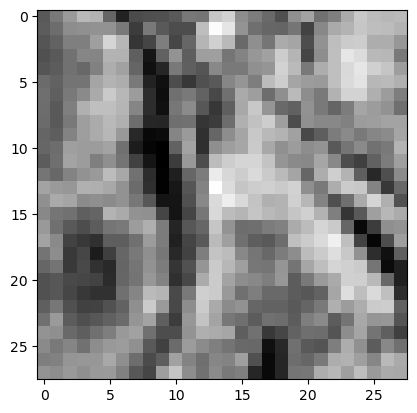

In [159]:
print("Label of this image is:", test_label)
plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)
comet_model.log_figure(figure=plt)

In [ ]:
#Correct!!!

In [175]:
label_map = {
    0: "Adipose",
    1: "Background",
    2: "Debris",
    3: "Lymphocytes",
    4: "Mucus",
    5: "Smooth Muscle",
    6: "Normal Colon Mucosa",
    7: "Cancer-Associated Stroma",
    8: "Colorectal Adenocarcinoma Epithelium"
}

all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in testset_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.to(device).to(torch.long)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs,dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        all_predictions.append(probabilities)
        all_labels.append(labels)
        all_images.append(images)

all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)
all_images = torch.cat(all_images)

predictions = all_predictions.cpu().numpy()
test_labels = all_labels.cpu().numpy()
test_images = all_images.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5686275..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40392154..0.6627451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011764705..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5921569..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5

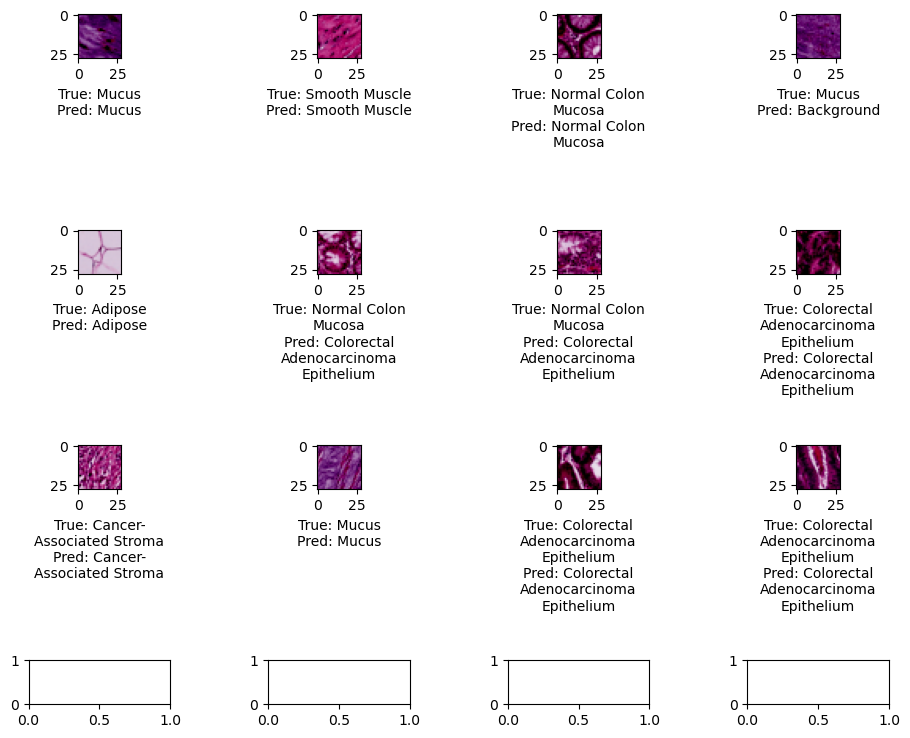

In [197]:
import textwrap
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
batch_size = images.size(0)
num_to_plot = min(num_images, batch_size)
fig, axes = plt.subplots(num_rows,num_cols, figsize=(10,8))
axes = axes.flatten()
for i in range(num_to_plot):
    img = images[i].cpu().permute(1,2,0)
    true_label = label_map[labels[i].item()]
    pred_label = label_map[predicted[i].item()]
    wrapped_true = textwrap.fill(f"True: {true_label}", width=20)
    wrapped_pred = textwrap.fill(f"Pred: {pred_label}", width=20)
    
    axes[i].imshow(img)
    axes[i].set_title("")
    axes[i].set_xlabel(f"{wrapped_true}\n{wrapped_pred}", fontsize=10)
    
plt.tight_layout(pad=3.0)
comet_model.log_figure(figure=plt)
plt.show()
